# Implementing MomentumIterativeMethod attack and transforming Grey box into a White box
Instead of Carlini-Wagner L2 attack, we implement NIPS-winning Momentum Iterative Method attack.

We also show transformation from the Grey box setup into a White box setup (at the end of the notebook).

In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17988940530368625049]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
import tensorflow as tf
import cleverhans
###########################
from cleverhans.attacks import Attack
from cleverhans.utils import AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_eval, tf_model_load
from cleverhans.model import Model, CallableModelWrapper
########### keras ############
from cleverhans.utils_keras import cnn_model as cnn_keras
from cleverhans.utils_keras import KerasModelWrapper

Using TensorFlow backend.


In [4]:
print(tf.__version__)
print(cleverhans.__version__)

1.6.0
2.0.0-5841f1ec3d80d0f4bbfc47c042d9cc58


# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [5]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
#(Vishal) Trained model in link to obtain pretrained model
model_path=os.path.join("keras_models", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [6]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
#(Vishal) Commented out since running on local machine without gpus
#sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), device_count={'CPU':2, 'GPU':0}))

sess=tf.Session()
print("Created TensorFlow session.")
import keras
from keras import backend as K
K.set_session(sess)
set_log_level(logging.DEBUG)

# Get MNIST test data
X_test, Y_test, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)


# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

model=cnn_keras()
preds = model(x)

Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [7]:
print(model_path)
print(os.path.exists(model_path + ".meta"))

rng = np.random.RandomState([2017, 11, 3])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    print('Loading the pre-trained Keras model')
    tf_model_load(sess, model_path)


keras_models/mnist
True
Loading the pre-trained Keras model
INFO:tensorflow:Restoring parameters from keras_models/mnist


In [8]:
# Evaluate the accuracy of the MNIST model on legitimate test examples

eval_params = {'batch_size': 128}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_test_clean_eval = accuracy

Test accuracy on legitimate test examples: 0.9878


# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


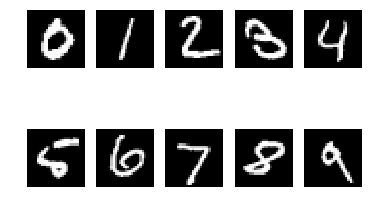

In [9]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the MI-FGSM attack:
https://arxiv.org/pdf/1710.06081.pdf

In [10]:
#(Kirill) Copied from cleverhans, with minor changes due to deprecated TensorFlow methods

class MomentumIterativeMethod(Attack):

    """
    The Momentum Iterative Method (Dong et al. 2017). This method won
    the first places in NIPS 2017 Non-targeted Adversarial Attacks and
    Targeted Adversarial Attacks. The original paper used hard labels
    for this attack; no label smoothing.
    Paper link: https://arxiv.org/pdf/1710.06081.pdf
    """

    def __init__(self, model, back='tf', sess=None):
        """
        Create a MomentumIterativeMethod instance.
        Note: the model parameter should be an instance of the
        cleverhans.model.Model abstraction provided by CleverHans.
        """
        if not isinstance(model, Model):
            model = CallableModelWrapper(model, 'probs')

        super(MomentumIterativeMethod, self).__init__(model, back, sess)
        self.feedable_kwargs = {'eps': np.float32,
                                'eps_iter': np.float32,
                                'y': np.float32,
                                'y_target': np.float32,
                                'clip_min': np.float32,
                                'clip_max': np.float32}
        self.structural_kwargs = ['ord', 'nb_iter', 'decay_factor']

    def generate(self, x, **kwargs):
        """
        Generate symbolic graph for adversarial examples and return.
        :param x: The model's symbolic inputs.
        :param eps: (required float) maximum distortion of adversarial example
                    compared to original input
        :param eps_iter: (required float) step size for each attack iteration
        :param nb_iter: (required int) Number of attack iterations.
        :param y: (optional) A tensor with the model labels.
        :param y_target: (optional) A tensor with the labels to target. Leave
                         y_target=None if y is also set. Labels should be
                         one-hot-encoded.
        :param ord: (optional) Order of the norm (mimics Numpy).
                    Possible values: np.inf, 1 or 2.
        :param decay_factor: (optional) Decay factor for the momentum term.
        :param clip_min: (optional float) Minimum input component value
        :param clip_max: (optional float) Maximum input component value
        """
        import tensorflow as tf

        # Parse and save attack-specific parameters
        assert self.parse_params(**kwargs)

        # Initialize loop variables
        momentum = 0
        adv_x = x

        # Fix labels to the first model predictions for loss computation
        y, nb_classes = self.get_or_guess_labels(x, kwargs)
        y = y / tf.reduce_sum(y, 1, keepdims=True)
        targeted = (self.y_target is not None)

        from cleverhans import utils_tf
        for i in range(self.nb_iter):
            # Compute loss
            preds = self.model.get_probs(adv_x)
            loss = utils_tf.model_loss(y, preds, mean=False)
            if targeted:
                loss = -loss

            # Define gradient of loss wrt input
            grad, = tf.gradients(loss, adv_x)

            # Normalize current gradient and add it to the accumulated gradient
            red_ind = list(xrange(1, len(grad.get_shape())))
            avoid_zero_div = tf.cast(1e-12, grad.dtype)
            grad = grad / tf.maximum(avoid_zero_div,
                                     tf.reduce_mean(tf.abs(grad),
                                                    red_ind,
                                                    keepdims=True))
            momentum = self.decay_factor * momentum + grad

            if self.ord == np.inf:
                normalized_grad = tf.sign(momentum)
            elif self.ord == 1:
                norm = tf.maximum(avoid_zero_div,
                                  tf.reduce_sum(tf.abs(momentum),
                                                red_ind,
                                                keepdims=True))
                normalized_grad = momentum / norm
            elif self.ord == 2:
                square = tf.reduce_sum(tf.square(momentum),
                                       red_ind,
                                       keepdims=True)
                norm = tf.sqrt(tf.maximum(avoid_zero_div, square))
                normalized_grad = momentum / norm
            else:
                raise NotImplementedError("Only L-inf, L1 and L2 norms are "
                                          "currently implemented.")

            # Update and clip adversarial example in current iteration
            scaled_grad = self.eps_iter * normalized_grad
            adv_x = adv_x + scaled_grad
            adv_x = x + utils_tf.clip_eta(adv_x - x, self.ord, self.eps)

            if self.clip_min is not None and self.clip_max is not None:
                adv_x = tf.clip_by_value(adv_x, self.clip_min, self.clip_max)

            adv_x = tf.stop_gradient(adv_x)

        return adv_x

    def parse_params(self, eps=0.3, eps_iter=0.06, nb_iter=10, y=None,
                     ord=np.inf, decay_factor=1.0,
                     clip_min=None, clip_max=None,
                     y_target=None, **kwargs):
        """
        Take in a dictionary of parameters and applies attack-specific checks
        before saving them as attributes.
        Attack-specific parameters:
        :param eps: (required float) maximum distortion of adversarial example
                    compared to original input
        :param eps_iter: (required float) step size for each attack iteration
        :param nb_iter: (required int) Number of attack iterations.
        :param y: (optional) A tensor with the model labels.
        :param y_target: (optional) A tensor with the labels to target. Leave
                         y_target=None if y is also set. Labels should be
                         one-hot-encoded.
        :param ord: (optional) Order of the norm (mimics Numpy).
                    Possible values: np.inf, 1 or 2.
        :param decay_factor: (optional) Decay factor for the momentum term.
        :param clip_min: (optional float) Minimum input component value
        :param clip_max: (optional float) Maximum input component value
        """

        # Save attack-specific parameters
        self.eps = eps
        self.eps_iter = eps_iter
        self.nb_iter = nb_iter
        self.y = y
        self.y_target = y_target
        self.ord = ord
        self.decay_factor = decay_factor
        self.clip_min = clip_min
        self.clip_max = clip_max

        if self.y is not None and self.y_target is not None:
            raise ValueError("Must not set both y and y_target")
        # Check if order of the norm is acceptable given current implementation
        if self.ord not in [np.inf, 1, 2]:
            raise ValueError("Norm order must be either np.inf, 1, or 2.")

        return True

In [11]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))

one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1

adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))

# Instantiate a CW attack object
# Model passed into MomentumIterativeMethod must be of type Model (as defined) so we pass our keras model to the KerasModelWrapper
model_wrap=KerasModelWrapper(model)

#(Kirill) Generate adversarial examples with MomentumIterativeMethod
mi_params = {'eps': 0.2,
             'eps_iter': 0.05,
             'nb_iter': 20,
             'ord': np.inf,
             'decay_factor': 1,
             'clip_min': 0,
             'clip_max': 1,
             'y_target': adv_ys
            }
mi = MomentumIterativeMethod(model_wrap, sess=sess)
adv = mi.generate_np(adv_inputs, **mi_params)

[INFO 2018-03-28 18:19:36,644 cleverhans] Constructing new graph for attack MomentumIterativeMethod


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



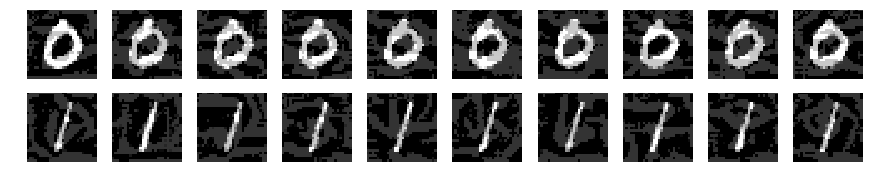

In [12]:
plt.figure(figsize=(15,15))
for i in range(2):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(adv[i*10+j,:,:,0],cmap='gray')
        plt.axis('off')

In [13]:
model.predict_classes(adv)

array([0, 1, 2, 3, 4, 5, 6, 7, 0, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 2, 5, 6, 2, 8, 2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
(model.predict_classes(adv)==model.predict_classes(adv_inputs)).sum()

15

In [15]:
np.save('adv_cw_targeted49_model9868.npy',adv)

# F-MNIST transfer learning here:

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

#  Fashion-MNIST dataset:

## Label	Description :
 - 0:	T-shirt/top
 - 1	Trouser
 - 2	Pullover
 - 3	Dress
 - 4	Coat
 - 5	trouser
 - 6	Shirt
 - 7	tshirt
 - 8	Bag
 - 9	Ankle boot
 
 
 Source: github.com/zalandoresearch/fashion-mnist

2


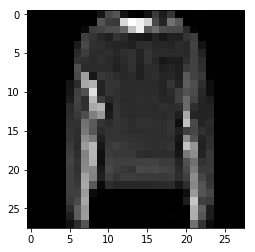

In [17]:
import sys

sys.path.append(os.path.join(os.getcwd(),'fashion_mnist'))
from utils import mnist_reader
#(Vishal) changed test to train
X_train_vec, y_train_vec = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='t10k')
#(Vishal) changed test to train
X_train_vec = X_train_vec.astype('float32')
X_test_vec = X_test_vec.astype('float32')
#(Vishal) changed test to train
X_train_vec /= 255
X_test_vec /= 255
from keras.utils import np_utils
#(Vishal) changed test to train
X_train_f=X_train_vec.reshape(60000,28,28,1)
X_test_f=X_test_vec.reshape(10000,28,28,1)
#(Vishal) changed test to train
Y_train_f=np_utils.to_categorical(y_train_vec, num_classes=10)
Y_test_f=np_utils.to_categorical(y_test_vec, num_classes=10)
#Let's display a tshirt:

%matplotlib inline
plt.imshow(X_test_f[243,:,:,0],cmap='gray')
print(np.argmax(Y_test_f[243]))
nb_classes=10

In [18]:
ind_tshirt=np.where(y_test_vec==0)[0][0:600]
ind_trouser=np.where(y_test_vec==1)[0][0:600]

X_tshirt=X_test_f[ind_tshirt]
X_trouser=X_test_f[ind_trouser]
#(Vishal) changed test to train
X_tshirt_train=X_tshirt[0:500]
#(Vishal) changed test to train
X_trouser_train=X_trouser[0:500]
X_tshirt_test=X_tshirt[500:]
X_trouser_test=X_trouser[500:]
#(Vishal) changed test to train
X_tt_train=np.vstack([X_trouser_train,X_tshirt_train])
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])

# Generate un-targeted adversarial examples for the 2-class FMNIST problem:

In [19]:
mi_params = {'eps': 0.25,
             'eps_iter': 0.05,
             'nb_iter': 20,
             'ord': np.inf,
             'decay_factor': 1,
             'clip_min': 0,
             'clip_max': 1,
             'y_target': None
            }

In [20]:
#(Kirill) Generate adversarial examples with MomentumIterativeMethod
mi = MomentumIterativeMethod(model_wrap, back='tf', sess=sess)
X_tt_train_adv = mi.generate_np(X_tt_train, **mi_params)

[INFO 2018-03-28 18:21:54,373 cleverhans] Constructing new graph for attack MomentumIterativeMethod


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [21]:
#(Kirill) Generate adversarial examples with MomentumIterativeMethod
mi = MomentumIterativeMethod(model_wrap, back='tf', sess=sess)
X_tt_test_adv = mi.generate_np(X_tt_test, **mi_params)

[INFO 2018-03-28 18:22:20,555 cleverhans] Constructing new graph for attack MomentumIterativeMethod


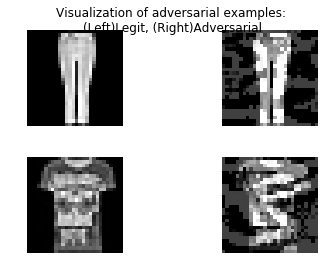

In [22]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[43,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[43,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[143,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[143,:,:,0],cmap='gray')
plt.axis('off')
plt.suptitle('Visualization of adversarial examples: \n(Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [23]:
(model.predict_classes(X_tt_test)==model.predict_classes(X_tt_test_adv)).sum()

0

In [24]:
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[6].output])

X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_train_feat=get_3rd_layer_output([X_tt_train, 0])[0]

X_tt_train_feat_adv=get_3rd_layer_output([X_tt_train_adv, 0])[0]
X_tt_test_feat_adv=get_3rd_layer_output([X_tt_test_adv, 0])[0]

y_tt_test=np.zeros(200)
y_tt_test[100:]=1

y_tt_train=np.zeros(1000)
y_tt_train[500:]=1

In [25]:
X_tt_test_feat[:,0]

array([0.5503826 , 0.        , 0.13611422, 0.42266604, 0.        ,
       1.0148538 , 0.5526203 , 1.0164927 , 1.3722296 , 0.13073052,
       0.6968076 , 0.88188493, 0.11200359, 0.6738504 , 1.001497  ,
       0.22576524, 0.7339825 , 0.4179108 , 0.35899723, 0.44777897,
       0.06866062, 0.26955017, 0.3413568 , 0.        , 0.6425289 ,
       0.4386805 , 0.        , 0.46918678, 0.00923382, 0.3209905 ,
       0.6301681 , 0.7641543 , 0.        , 0.38282633, 0.5324605 ,
       0.8274627 , 0.27822343, 0.        , 0.8997735 , 1.0458293 ,
       0.        , 0.        , 0.29673737, 0.5990784 , 0.3504678 ,
       1.064376  , 0.6318039 , 0.        , 0.32631373, 0.6818948 ,
       1.7584597 , 1.4237841 , 0.        , 0.        , 0.        ,
       0.        , 0.31165895, 0.22844811, 0.34390315, 0.9910431 ,
       1.0210991 , 0.27690947, 0.49062014, 1.2808709 , 0.6305193 ,
       0.6035753 , 0.74643505, 0.        , 0.6980756 , 0.        ,
       0.24085857, 0.4860042 , 0.15338975, 0.        , 0.57384

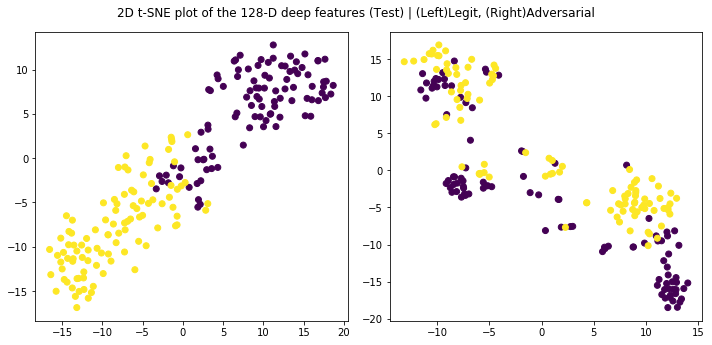

In [26]:
from sklearn.manifold import TSNE

X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)

X_tt_embedded_test_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat_adv)
plt.subplot(122)
plt.scatter(X_tt_embedded_test_adv[:,0],X_tt_embedded_test_adv[:,1],c=y_tt_test)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Test) | (Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
print("Confusion matrix for rbf kernel without adversary")
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
print("Confusion matrix for linear kernel without adversary")
print(confusion_matrix(y_tt_test, y_pred_svc))

Confusion matrix for rbf kernel without adversary
[[ 91   9]
 [  0 100]]
Confusion matrix for linear kernel without adversary
[[99  1]
 [ 3 97]]


In [28]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc_adv=clf.predict(X_tt_test_feat)
print("Confusion matrix for rbf kernel with training adversary")
print(confusion_matrix(y_tt_test, y_pred_svc_adv))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc_adv=clf.predict(X_tt_test_feat)
print("Confusion matrix for linear kernel with training adversary")
print(confusion_matrix(y_tt_test, y_pred_svc_adv))

Confusion matrix for rbf kernel with training adversary
[[83 17]
 [ 1 99]]
Confusion matrix for linear kernel with training adversary
[[99  1]
 [88 12]]


Adversarial examples based on the initial network for digit recognition doesn't necessarily do a job of confusing the trousers vs t-shirts classifier.

For better defence, use rbf kernel for the SVM.

# Grey box into White Box
We show that grey box setup can be transformed into white box given the known outputs of the classifier.

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')

In [92]:
#(Kirill) Train black-box SVM classifier
clf.fit(X_tt_train_feat, y_tt_train) 

y_train_pred_svc = clf.predict(X_tt_train_feat)
y_train_pred_svc = np_utils.to_categorical(y_train_pred_svc, num_classes=2)

y_test_pred_svc = clf.predict(X_tt_test_feat)
y_test_pred_svc = np_utils.to_categorical(y_test_pred_svc, num_classes=2)

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [94]:
nb_feat = X_tt_train_feat.shape[1]

#(Kirill) Build a model that works as adversarial substitution for the SVM classifier
model_white = Sequential()
model_white.add(Dense(2, input_shape=(nb_feat,), activation='softmax'))

model_white.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

#(Kirill) Train the model on black-box SVM outputs
model_white.fit(X_tt_train_feat, y_train_pred_svc,
                epochs=10,
                validation_data=(X_tt_test_feat, y_test_pred_svc))


Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3578 - acc: 0.9060 - val_loss: 0.3098 - val_acc: 0.8950
Epoch 2/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.2372 - acc: 0.9470 - val_loss: 0.2427 - val_acc: 0.9150
Epoch 3/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.1854 - acc: 0.9560 - val_loss: 0.2014 - val_acc: 0.9300
Epoch 4/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.1535 - acc: 0.9660 - val_loss: 0.1734 - val_acc: 0.9400
Epoch 5/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.1318 - acc: 0.9710 - val_loss: 0.1520 - val_acc: 0.9600
Epoch 6/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.1157 - acc: 0.9750 - val_loss: 0.1347 - val_acc: 0.9650
Epoch 7/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.1031 - acc: 0.9770 - val_loss: 0.1208 - val_acc: 0.9750
Epoch 8/1

In [95]:
#(Kirill) Build a new adversarial model that combines white-box CNN with the adversarial classifier
model_adv = Sequential()

model_feat_layers = model.layers[:-2]
for layer in model_feat_layers:
    model_adv.add(layer)
for layer in model_white.layers:
    model_adv.add(layer)
    
model_adv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [96]:
mi_params = {'eps': 0.1,
             'eps_iter': 0.05,
             'nb_iter': 20,
             'ord': np.inf,
             'decay_factor': 1,
             'clip_min': 0,
             'clip_max': 1,
             'y_target': None
            }

In [97]:
#(Kirill) Get adversarial train inputs
mi = MomentumIterativeMethod(model_adv, back='tf', sess=sess)
X_tt_train_adv = mi.generate_np(X_tt_train, **mi_params)

[INFO 2018-03-28 13:54:15,116 cleverhans] Constructing new graph for attack MomentumIterativeMethod


In [98]:
#(Kirill) Get adversarial test inputs
mi = MomentumIterativeMethod(model_adv, back='tf', sess=sess)
X_tt_test_adv = mi.generate_np(X_tt_test, **mi_params)

[INFO 2018-03-28 13:54:38,404 cleverhans] Constructing new graph for attack MomentumIterativeMethod


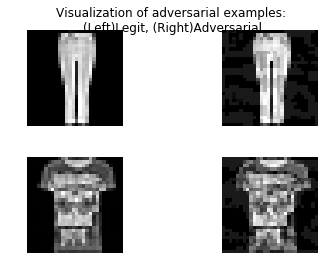

In [99]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[43,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[43,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[143,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[143,:,:,0],cmap='gray')
plt.axis('off')
plt.suptitle('Visualization of adversarial examples: \n(Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [100]:
#(Kirill) The adversary who knows training labels can produce faulty testing examples
X_tt_test_feat_adv=get_3rd_layer_output([X_tt_test_adv, 0])[0]

y_pred_svc_adv=clf.predict(X_tt_test_feat_adv)
print("Confusion matrix for rbf kernel with testing adversary")
print(confusion_matrix(y_tt_test, y_pred_svc_adv))

Confusion matrix for rbf kernel with testing adversary
[[32 68]
 [55 45]]


In [102]:
#(Kirill) The adversary can also interfere with a training process to misclassify real data
X_tt_train_feat_adv=get_3rd_layer_output([X_tt_train_adv, 0])[0]

clf = SVC( kernel='rbf')
clf.fit(X_tt_train_feat_adv, y_tt_train) 

y_pred_svc=clf.predict(X_tt_test_feat)
print("Confusion matrix for rbf kernel with training adversary")
print(confusion_matrix(y_tt_test, y_pred_svc))

Confusion matrix for rbf kernel with training adversary
[[65 35]
 [34 66]]
